# Homework 2: Multiple Linear Regression (50 points)

**Reading**: Textbook chapter [15](https://www.inferentialthinking.com/chapters/15/Prediction) and  [16](https://www.inferentialthinking.com/chapters/16/Inference_for_Regression).

**Pandas Cheat Sheet**: There are several Pandas documentation files you can find with a simple search. This is one that is short and informative: https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf

Please complete this notebook by filling in the cells provided. Before you begin, execute the following cell to load the needed functions. Each time you start your server, you will need to execute this cell again to load them.  

Homework 2 is due Tuesday, 1/29 at 9:30am. Late work will not be accepted.  

In [3]:
# Don't change this cell; just run it. 

import numpy as np
from datascience import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import pandas as pd

from IPython.display import HTML, display

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## 1. Birth Weight (50 points) ##

The data below contains the following variables for 1,174 mother-baby pairs: the baby’s birth weight in ounces, the number of gestational days, the mother’s age in completed years, the mother’s height in inches, pregnancy weight in pounds, and whether or not the mother smoked during pregnancy.


This data was used in one of the lectures last quarter (Lecture 16) but the only question investigated there was on the association of maternal smoking with birth weight. Here we will try to provide a better understanding of the factors that influence birth weight.

**The variable of interest is Birth Weight.**

In [4]:
baby_df=pd.read_csv("baby.csv")
baby_df.head(10)

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False
5,138,244,33,62,178,False
6,132,245,23,65,140,False
7,120,289,25,62,125,False
8,143,299,30,66,136,True
9,140,351,27,68,120,False


#### Question 1 ( Visualization, 10 points)

Draw scatter plots of Birth Weight (on the y-axis) versus the four quantitative variables. Also display a graph that shows the relation between Birth Weight and Maternal Smoker. Comment on what the plots show.

''

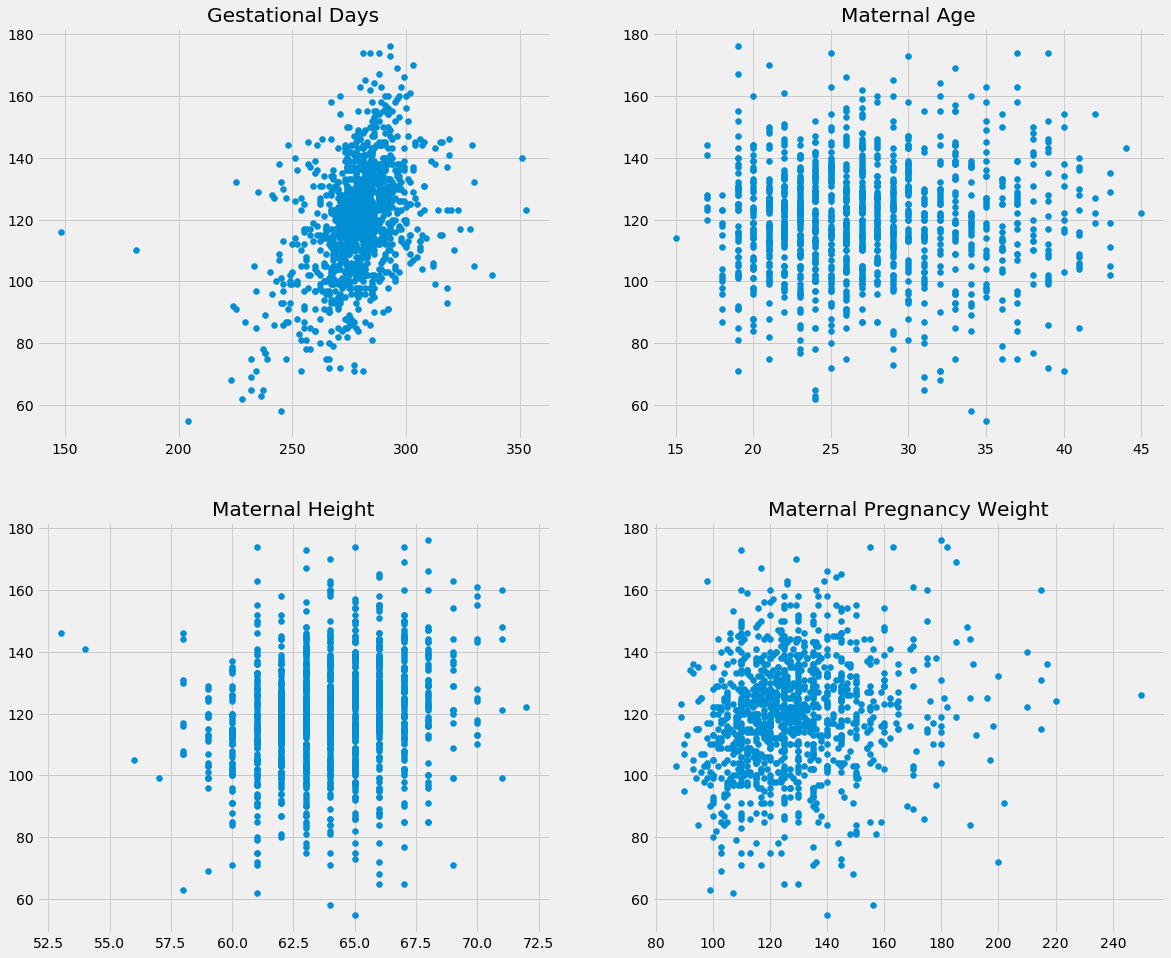

In [5]:
plots.figure(figsize=(18, 24))

plots.subplot(3, 2, 1)
plots.scatter(baby_df['Gestational Days'],baby_df['Birth Weight'])
plots.title('Gestational Days')

plots.subplot(3, 2, 2)
plots.scatter(baby_df['Maternal Age'],baby_df['Birth Weight'])
plots.title('Maternal Age')

plots.subplot(3, 2, 3)
plots.scatter(baby_df['Maternal Height'],baby_df['Birth Weight'])
plots.title('Maternal Height')

plots.subplot(3, 2, 4)
plots.scatter(baby_df['Maternal Pregnancy Weight'],baby_df['Birth Weight'])
plots.title('Maternal Pregnancy Weight')
;

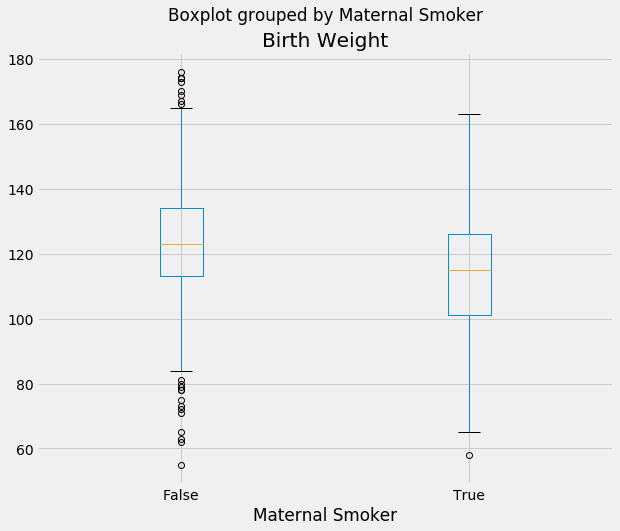

In [6]:
fig, ax = plots.subplots(figsize=(10,8))
baby_df.boxplot(column=['Birth Weight'], by='Maternal Smoker', ax=ax)

There appears to be a general upwards trend with gestational days, maternal height, and maternal pregnancy weight and birth weight where as those three things increase, so does birth weight. There is not a distinguishable pattern for maternal age. 

#### Question 2 (Simple Linear Regression, Gestational Age, 5 points)

Fit a simple linear regression model for "Gestational Days" (as the predictor) and Birth Weigth (as the response). Calculate the intercept, the slope and a 95% Confidence Interval for the slope. Briefly discuss your results by: (i) interpreting the slope; (ii) discussing the signficance of the predictor (is there evidence that the slope is different than 0?); (iii) commenting on whether the results make sense (does it make sense for birth weight to be associated with gestational age?).


In [7]:
def standard_units(x):
    "Convert any array of numbers to standard units."
    return (x - np.average(x))/np.std(x,ddof=1)  

def correlation(x, y):
    x_in_standard_units = standard_units(x)
    y_in_standard_units = standard_units(y)
    if len(x)!=len(y):
        raise ValueError('arrays are of different lengths')
    return sum(x_in_standard_units * y_in_standard_units)/(len(x)-1)

def slope(x, y):
    if len(x)!=len(y):
        raise ValueError('arrays are of different lengths')
    return correlation(x, y)* np.std(y,ddof=1)/np.std(x,ddof=1)
    
    
def intercept(x, y):
    b1 = slope(x, y)
    return np.average(y) - b1 * np.average(x)


def bootstrap_slope(df,x, y, repetitions):
    # the number of observations
    n=df.shape[0]
    # Bootstrap the scatter, find the slope, collect
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = df.sample(n,replace=True)
        bootstrap_slope = slope(bootstrap_sample[x], bootstrap_sample[y])
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(df[x],df[y])
    
    # Display results
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the slope of the true line:')
    print(left, 'to', right)

In [8]:
print('intercept:', intercept(baby_df['Gestational Days'], baby_df['Birth Weight']))
bootstrap_slope(baby_df,'Gestational Days','Birth Weight',1000)

intercept: -10.754138914450422
Slope of regression line: 0.4665568769492159
Approximate 95%-confidence interval for the slope of the true line:
0.37843745141553325 to 0.554649087189469


The slope of 0.466 indidates that on average for every one unit increase in gestational age, there is a 0.466 unit increase in birth weight. There appears to be evidence that the slope is different than zero as zero is not contained in the 95% confidence interval. This makes logical sense as biologically, I would expect that a baby keeps on growing as long as it is gestational, and the longer it is gestational, the more time it has to grow. 

#### Question 3 (Simple Linear Regression, Maternal Age, 5 points)

Repeat Question 2 for Maternal Age.


In [9]:
print('intercept:', intercept(baby_df['Maternal Age'], baby_df['Birth Weight']))
bootstrap_slope(baby_df,'Maternal Age','Birth Weight',1000)

intercept: 117.14790872185156
Slope of regression line: 0.08500766941582519
Approximate 95%-confidence interval for the slope of the true line:
-0.0984717491198696 to 0.2628474396593441


A slope of 0.085 indicates that on average, for every one unit increase in maternal age (one year), there is a 0.085 unit increase in birth weight. The slope does not appear to be significantly different than zero since zero is in the 95% confidence interval. This does make logical sense as the baby's weight would probably be based off genetic features of the mother rather than her age (everyone ages, this isn't determinant of genetics).

#### Question 4 (Simple Linear Regression, Maternal Height, 5 points)

Repeat Question 2 for Maternal Height.


In [10]:
print('intercept:', intercept(baby_df['Maternal Height'], baby_df['Birth Weight']))
bootstrap_slope(baby_df,'Maternal Height','Birth Weight',1000)

intercept: 24.796263075888632
Slope of regression line: 1.478019351928435
Approximate 95%-confidence interval for the slope of the true line:
1.0262247692981274 to 1.915802288392326


A slope of 1.478 indicates that on average, for every one unit increase in maternal height, there is a 1.47 increase in birth weight. The slope does appear to be significantly different than zero since zero is not contained on the 95% confidence interval. This makes logical sense as a mother who is genetically taller will have likely passed on traits of being bigger overall genetically to her child as well. 

#### Question 5 (Simple Linear Regression, Maternal Smoking, 5 points)

Fit a simple linear regression model with "Maternal Smoker" as the predictor (x variable). Recall from class that you need to create a dummy variable for that. Answer the same questions as in Questions 2-4.


In [12]:
baby_df['smoker_true'] = baby_df['Maternal Smoker'].map({True:1, False:0})

baby_df.head()

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker,smoker_true
0,120,284,27,62,100,False,0
1,113,282,33,64,135,False,0
2,128,279,28,64,115,True,1
3,108,282,23,67,125,True,1
4,136,286,25,62,93,False,0


In [13]:
print('intercept:', intercept(baby_df['smoker_true'], baby_df['Birth Weight']))
bootstrap_slope(baby_df,'smoker_true','Birth Weight',1000)

intercept: 123.08531468531473
Slope of regression line: -9.266142572025034
Approximate 95%-confidence interval for the slope of the true line:
-11.425278299203459 to -7.232729360087827


A slope of -9.266 indicates that on average, if a person is a smoker, there is a 9.266 unit decrease in birth weight. The slope does appear to be significantly different than zero since zero is not contained on the 95% confidence interval. This makes logical sense as a mother who is a smoker may also be ignoring other prenatal care instructions and adversely affecting the baby's health, and therefore growth. 

#### Question 6 (Multiple Linear Regression, 10 points)

Fit a multiple linear regression with four predictors: Gestational Days, Maternal Smoking, Maternal Height and Maternal Pregagncy Weight. Here you are required only to find the least square parameters (the value of the parameters that minimize the least squares function). Discuss whether these parameters have changed dramatically from when you fitted simple linear regressions (for the three variables for which you did that above).

In [29]:
## OLS multiple linear regression code from class adapted to this data set
##DID NOT USE THIS CODE, LOOK AT CELLS BELOW FOR MORE FUNCTIONAL/PRETTY CODE

# # code here and in additional cells if needed
# n=baby_df.shape[0]

# predicted1 = make_array()
    
# for i in range(n):
#     # drop the i-th row
#     tmp_df=baby_df.drop(i)

#     # this is residual sum of squares function
#     def rss(b0,b1,b2,b3,b4):
#         estimate = b0+b1*tmp_df['Gestational Days']+b2*tmp_df['smoker_true'] + b3*tmp_df['Maternal Height']+b4*tmp_df['Maternal Pregnancy Weight']
#         return (np.mean((tmp_df['Birth Weight'] - estimate) ** 2))

#     # the estimated values of the parameters
#     tmp_fit=minimize(rss,method="CG")

#     #the predicted price
#     tmp_pred=tmp_fit[0]+tmp_fit[1]*baby_df['Gestational Days'][i] \
#             +tmp_fit[2]*baby_df['smoker_true'][i]+tmp_fit[3]*baby_df['Maternal Height'][i] \
#             +tmp_fit[4]*baby_df['Maternal Pregnancy Weight'][i]
    
#     # appending the result
#     predicted1 = np.append(predicted1, tmp_pred)
    
# predicted1[0:10]

In [27]:
baby_model = ols("""baby_df['Birth Weight'] ~ baby_df['Gestational Days']
                                            + baby_df['smoker_true'] 
                                            + baby_df['Maternal Height']
                                            + baby_df['Maternal Pregnancy Weight']""", data=baby_df).fit()
baby_model_summary = baby_model.summary()
HTML(baby_model_summary.as_html())

The parameteres did not dramatically change from when we gitten the simple linear regressions. Although slightly different (not more than 1.0 off the original estimates), overall each variable appears to have a similar effect even when accounting for other variables. This is further solidified by the fact that they are all statistically significant at a 0.05 level and msot are at a 0.01 level. However, the r squared value of 0.252 does not indicate a good fit for linearity. 

#### Question 7 (Prediction and cross validation, 10 points)

The goal here is to construct a model that predicts birth weight. The performance of the models is assessed using "leave one out" cross validation - similarly to what we did in class for the housing data. You should do this for two models: (i) the model in Question 6; (ii) a model of your choice. For the model of your choice, pick something that makes sense to you (you will not be evaluated on whether it predicts better than the model in Q6).

**For computational reasons (recall the discussion in class), you can do the cross-validation only for a subset of the data, let's say the first 100 subjects.**

I chose a model that predicts birth weight using predictors of gestational days, maternal smoker, and maternal height. Maternal pregnancy weight did not seem to have a large coefficient and although significat, could be simply adding to the model unnecessarily. Maternal age also did not seem to have a large coefficient or seem relevant in determining the best fit line when looking at simple linear regression. While maternal smoker and maternal height had larger coefficients, logically, it seems to me that gestational age is also a very important biological factor and therefore chose to include it.

In [28]:
baby_model2 = ols("""baby_df['Birth Weight'] ~ baby_df['Gestational Days']
                                            + baby_df['smoker_true'] 
                                            + baby_df['Maternal Height']""", data=baby_df).fit()

baby_model2_summary = baby_model2.summary()
HTML(baby_model2_summary.as_html())

The predictor coefficients appear to be approximately the same, although they all increased by a tenth or more. However, while all the predictors are significant at the 0.001 level, which is highly statistically significant, the r squared value decreased to 0.248 which indicates that its a less good fit than the first model. 